## Master's thesis - Recurrent Neural Networks for Lagranigan Tracking of Microorganisms
#### Mathilda Gustafsson
#### 2025-05-29
#### This notebook is used to train an RNN.
#### Note that this notebook uses latex in combination with matplotlib

Load packages

In [ ]:
# Load packages
import deeptrack as dt
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.init as init
import importlib 

import logging
logging.getLogger('matplotlib.texmanager').setLevel(logging.WARNING)

# change font of the plots
change_fonts = True

if change_fonts:
    plt.rcParams['font.family'] = ['serif']
    plt.rcParams['font.serif'] = ['CMU Serif']
    plt.rc('axes', unicode_minus=False)
    plt.rcParams['text.usetex'] = True

light_grey = np.array([232, 232, 232]) / 255
mid_grey = np.array([137, 137, 137]) / 255
dark_grey = np.array([96, 96, 96]) / 255

IMAGE_SIZE = 128

Load classes for datasets and models

In [3]:
import definitions_of_classes
importlib.reload(definitions_of_classes)
from definitions_of_classes import datasetSequentialImages, RNN

Load datasets and create dataloaders

In [ ]:
training_set_length = 300
validation_set_length = 100

dataset_training = torch.load('./Data/dataTrain.pt')
dataset_validation = torch.load('./Data/dataValidation.pt')

dataLoader_training = DataLoader(dataset = dataset_training, batch_size = 1, shuffle = True) 
dataLoader_validation = DataLoader(dataset = dataset_validation, batch_size = 1, shuffle = False)

Initialize model, loss functions and optimizer

In [ ]:
model_rnn = RNN()

loss_function_regression = nn.L1Loss()
loss_function_classification = nn.CrossEntropyLoss()

learning_rate = 1e-3
optimizer = torch.optim.Adam(model_rnn.parameters(), lr = learning_rate)

Initialize weights

In [ ]:
def init_weights(layer):
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
        init.kaiming_normal_(layer.weight, nonlinearity='leaky_relu')
        if layer.bias is not None:
            init.zeros_(layer.bias)
    elif isinstance(layer, nn.Linear):
        init.xavier_normal_(layer.weight)
        if layer.bias is not None:
            init.zeros_(layer.bias)

model_rnn.apply(init_weights)

recurrent_nn(
  (ReLU): ReLU()
  (leakyReLU): LeakyReLU(negative_slope=0.01)
  (batch_norm_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_1): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(16, 16, kernel_size=(2, 2), stride=(1, 1)

Define functions for training one epoch, with different loss functions

In [ ]:
##############################
# Training with only L1 loss
##############################

def one_epoch_training_regression_loss(dataLoader_training, training_loss_per_step, iter_step):

    epoch_loss = 0

    # load data (one sequence at a time)
    for i, data in enumerate(dataLoader_training):

        images, positions = data
        n_in_sequence = len(images)

        optimizer.zero_grad()
        loss_one_sequence = 0

        # pass first images to store some memory
        output = model_rnn(images[0], is_initial_image = True)

        for memory_idx in range(1, 10):
            output = model_rnn(images[memory_idx], is_initial_image = False)
        
        # loop through rest of the sequence
        for j in range(10, n_in_sequence):

            output = model_rnn(images[j], is_initial_image = False)

            positions_at_time_step = positions[j].numpy()[0]
            index_true_position = np.where(positions_at_time_step[:,3] == 1)[0][0]
            true_position = positions_at_time_step[index_true_position,0:2] # change to 0:3 for z prediction

            loss = loss_function_regression(output[0], torch.tensor(true_position))
            loss_one_sequence += loss

            # log loss
            training_loss_per_step[iter_step] = loss.item()
            iter_step += 1
            epoch_loss += loss.item()

        # update weights after iterating through one sequence
        loss_one_sequence.backward()
        optimizer.step()         

    return training_loss_per_step, epoch_loss, iter_step


def one_epoch_validation_regression_loss(dataLoader_validation):

    loss_per_epoch = 0

    for data in iter(dataLoader_validation):
        images, positions = data
        n_in_sequence = len(images)

        # pass images to store memory
        output = model_rnn(images[0], is_initial_image = True)

        for memory_idx in range(1, 10):
            output = model_rnn(images[memory_idx], is_initial_image = False)

        # loop through rest of the sequence
        for i in range(10, n_in_sequence):

            output = model_rnn(images[i], is_initial_image = False)

            positions_at_time_step = positions[i].numpy()[0]
            index_true_position = np.where(positions_at_time_step[:,3] == 1)[0][0]
            true_position = positions_at_time_step[index_true_position,0:2] # change to 0:3 for z prediction
            
            loss = loss_function_regression(output[0], torch.tensor(true_position))
            loss_per_epoch += loss.item()

    return loss_per_epoch


###########################################
# Training with L1 and classification loss
###########################################

def compute_distances_to_true_position(prediction, true_position, additional_positions):

    num_particles_total = 1 + len(additional_positions)
    distances = torch.zeros(num_particles_total)

    # distance to true position
    distances[0] =  (prediction - torch.tensor(true_position)).pow(2).sum().sqrt()

    # distances to additional positions
    for i in range(1, num_particles_total):
        additional_position = additional_positions[i-1][0:2] # change to 0:3 to z prediction
        distances[i] = (prediction - torch.tensor(additional_position)).pow(2).sum().sqrt()

    return distances


def one_epoch_training_regression_classification_loss(dataLoader_training, training_loss_per_step, iter_step, weight_reg_loss, weight_class_loss):

    epoch_loss = 0
    epoch_regression_loss = 0
    epoch_classification_loss = 0

    # load data (one sequence at a time)
    for i, data in enumerate(dataLoader_training):
        
        images, positions = data
        n_in_sequence = len(images)

        optimizer.zero_grad()
        loss_one_sequence = 0

        # pass first images to store some memory
        output = model_rnn(images[0], is_initial_image = True)
        for memory_idx in range(1, 10):
            output = model_rnn(images[memory_idx], is_initial_image = False)
        
        # loop through rest of the sequence
        for j in range(10, n_in_sequence):

            output = model_rnn(images[j], is_initial_image = False)

            positions_at_time_step = positions[j].numpy()[0]
            index_true_position = np.where(positions_at_time_step[:,3] == 1)[0][0]
            true_position = positions_at_time_step[index_true_position,0:2] # change to 0:3 for z prediction
            additional_positions = np.delete(positions_at_time_step, index_true_position, axis = 0)

            # regression loss
            loss_regression = loss_function_regression(output[0], torch.tensor(true_position))

            # compute probability vector for classification
            distances = compute_distances_to_true_position(output, true_position, additional_positions)
            probabilities_for_classification_of_correct_particle = nn.functional.softmin(distances, dim = 0)

            # classification loss
            num_particles = len(positions_at_time_step[:,0])
            target_classification = np.zeros(num_particles)
            target_classification[0] = 1
            target_classification = torch.tensor(target_classification)
            loss_classification = loss_function_classification(probabilities_for_classification_of_correct_particle, target_classification)

            # log loss
            total_loss = weight_reg_loss * loss_regression + weight_class_loss * loss_classification
            loss_one_sequence += total_loss
            training_loss_per_step[iter_step] = total_loss.item()
            iter_step += 1
            epoch_loss += total_loss.item()
            epoch_regression_loss += loss_regression.item()
            epoch_classification_loss += loss_classification.item()

        # update weights after iterating through one sequence
        loss_one_sequence.backward()
        optimizer.step()         

    return training_loss_per_step, epoch_loss, epoch_regression_loss, epoch_classification_loss, iter_step


def one_epoch_validation_regression_classification_loss(dataLoader_validation, weight_reg_loss, weight_class_loss):

    loss_per_epoch = 0

    for data in iter(dataLoader_validation):
        images, positions = data
        n_in_sequence = len(images)

        # pass images to store memory
        output = model_rnn(images[0], is_initial_image = True)

        for memory_idx in range(1, 10):
            output = model_rnn(images[memory_idx], is_initial_image = False)

        # loop through rest of the sequence
        for i in range(10, n_in_sequence):

            positions_at_time_step = positions[i].numpy()[0]
            index_true_position = np.where(positions_at_time_step[:,3] == 1)[0][0]
            true_position = positions_at_time_step[index_true_position,0:2] # change to 0:3 for z prediction
            additional_positions = np.delete(positions_at_time_step, index_true_position, axis = 0)

            output = model_rnn(images[i], is_initial_image = False)
            
            # regresison loss
            loss_regression = loss_function_regression(output[0], torch.tensor(true_position))

            # classification loss
            distances = compute_distances_to_true_position(output, true_position, additional_positions)
            probabilities_for_classification_of_correct_particle = nn.functional.softmin(distances, dim = 0)

            num_particles = len(positions_at_time_step[:,0])
            target_classification = np.zeros(num_particles)
            target_classification[0] = 1
            target_classification = torch.tensor(target_classification)
            loss_classification = loss_function_classification(probabilities_for_classification_of_correct_particle, target_classification)

            total_loss = weight_reg_loss * loss_regression + weight_class_loss * loss_classification 
            loss_per_epoch += total_loss.item()

    return loss_per_epoch

Train the RNN

In [ ]:
loss_used = "L1" # or "L1+class"

images_per_sequence = 300
images_per_sequence_used_for_prediction = images_per_sequence - 10

n_epochs = 10
n_steps_per_epoch_validation = validation_set_length * images_per_sequence_used_for_prediction
n_steps_per_epoch_train = training_set_length * images_per_sequence_used_for_prediction
n_steps_train = n_epochs * n_steps_per_epoch_train

training_loss_per_epoch = np.zeros(n_epochs)
training_loss_per_step = np.zeros(n_steps_train) 
validation_loss_per_epoch = np.zeros(n_epochs)

weight_reg_loss = 1
weight_class_loss = 0.02 # classification loss is about 50 times larger, use weight 0.02 to make similar to regression loss

iter_step = 0
for epoch in range(n_epochs):

    # set training mode
    model_rnn.train(True)

    if loss_used == "L1":

        # train one epoch
        training_loss_per_step, epoch_loss, iter_step = one_epoch_training_regression_loss(dataLoader_training, training_loss_per_step, iter_step)

        # set eval model
        model_rnn.eval()

        # check model on validation data
        validation_loss_per_epoch_sum = one_epoch_validation_regression_loss(dataLoader_validation)


    elif loss_used == "L1+class":

        # train one epoch
        training_loss_per_step, epoch_loss, epoch_regression_loss, epoch_classification_loss, iter_step = one_epoch_training_regression_classification_loss(dataLoader_training, training_loss_per_step, iter_step, weight_reg_loss, weight_class_loss)
   
        # set eval model
        model_rnn.eval()

        # check model on validation data
        validation_loss_per_epoch_sum = one_epoch_validation_regression_classification_loss(dataLoader_validation, weight_reg_loss, weight_class_loss) 
    
    
    # store loss values
    training_loss_per_epoch[epoch] = epoch_loss / n_steps_per_epoch_train
    validation_loss_per_epoch[epoch] = validation_loss_per_epoch_sum / n_steps_per_epoch_validation
    
    print(f"epoch: {epoch + 1}, Training loss: {epoch_loss / n_steps_per_epoch_train}, Test loss: {validation_loss_per_epoch_sum / n_steps_per_epoch_validation}")
    if loss_used == "L1+class":
        print(f"epoch: {epoch + 1}, Training regression loss: {epoch_regression_loss / n_steps_per_epoch_train}, Training classification loss: {epoch_classification_loss / n_steps_per_epoch_train}")


epoch: 21, Training loss: 0.0404140106619428, Test loss: 0.03764464497645366
epoch: 21, Training regression loss: 0.02057323326581511, Training classification loss: 0.9920388698064048
epoch: 22, Training loss: 0.03894943443817634, Test loss: 0.039075849905897894
epoch: 22, Training regression loss: 0.019119960984621924, Training classification loss: 0.9914736726777307
epoch: 23, Training loss: 0.03898303730532702, Test loss: 0.0372868599444217
epoch: 23, Training regression loss: 0.019155879429273905, Training classification loss: 0.9913578938026538
epoch: 24, Training loss: 0.037540253734173766, Test loss: 0.03748716627729328
epoch: 24, Training regression loss: 0.01772676876452805, Training classification loss: 0.990674248482304
epoch: 25, Training loss: 0.0362352126451298, Test loss: 0.037291605707283404
epoch: 25, Training regression loss: 0.01643160228405533, Training classification loss: 0.990180518053729
epoch: 26, Training loss: 0.03703556572889469, Test loss: 0.036696650306767

Save model

In [ ]:
torch.save(model_rnn.state_dict(), f"./rnn.pt")

Visualize training process

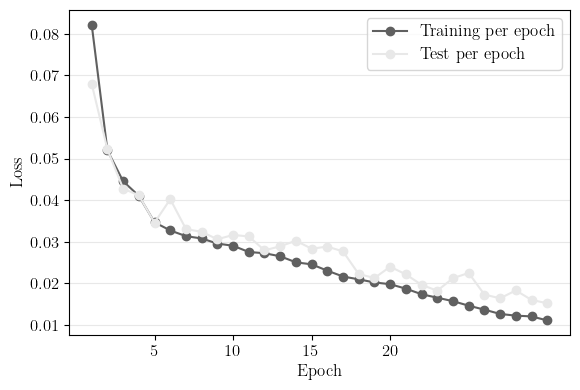

In [ ]:
fig, ax = plt.subplots(1,1)
font_size = 12

epochs = np.arange(1, n_epochs + 1, 1)

ax.plot(epochs, training_loss_per_epoch[0:], marker = "o", label = "Training per epoch", color = dark_grey)
ax.plot(epochs, validation_loss_per_epoch[0:], marker = "o", label = "Test per epoch", color = light_grey)

ax.set_xlabel("Epoch", fontsize = font_size)
ax.set_ylabel("Loss", fontsize = font_size)

ax.set_xticks([5,10,15,20])
ax.tick_params(axis='both', which='major', labelsize = 12)
ax.tick_params(axis='both', which='minor', labelsize = 12)
ax.legend(fontsize = font_size)

ax.grid(axis="y", color = light_grey)

fig.set_size_inches(5.9, 4)
plt.tight_layout()
#plt.savefig("./training_log.pdf")
plt.show()